<a href="https://colab.research.google.com/github/LivingstonTardzenyuy/Deep-Learning-with-TensorFlow/blob/main/06_transfer_learning_in_tensorflow_part_3_scaling_up.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning with TensorFlow Part 3: Scaling up(Food Vision mini)

We've seen the power of transfer learning feature extraction and fine-tuning, now it's time to scale up to all of the classes in Food101 (101 total classes of food).

The goal is to beat original Food101 paper with 10% of the trainig data using deep learning

In [1]:
!nvidia-smi

Thu Dec 26 09:02:09 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## creating helper functions.

In previous notebook, we've created a series of helper functions to do different tasks, let's download them.

In [2]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/refs/heads/main/extras/helper_functions.py

--2024-12-26 09:02:10--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/refs/heads/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-12-26 09:02:10 (96.0 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
# Import series of helper functions in notebook.

from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir

## 101 Food Classes: Working with less data

our goal is to beat original Food101 paper with 10% of the trainig data using deep learning.

The data we're downloading comes from original Food101 dataset but has been processed using image_data_modifications notebook in github.


In [4]:

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
unzip_data("101_food_classes_10_percent.zip")


train_dir = "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"

--2024-12-26 09:02:22--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.12.207, 74.125.26.207, 172.217.204.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.12.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G   111MB/s    in 17s     

2024-12-26 09:02:39 (93.4 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [5]:
# How many image/classes are there ?.

walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/train'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/sashimi'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/macaroni_and_cheese'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/spaghetti_carbonara'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/shrimp_and_grits'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/edamame'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/frozen_yogurt'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/croque_madame'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/cheesecake'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/prime_rib'.
There are 0 directories an

In [6]:
# Setup data inputs.

import tensorflow as tf

IMG_SIZE = (224, 224)
train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                label_mode='categorical',
                                                                                image_size = IMG_SIZE,)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode = "categorical",
                                                                image_size = IMG_SIZE,
                                                                shuffle=False # don't shuffle the test data for prediction analysis.
                                                                )


Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


# Train a big dog model with transfer learning on 10% of 101 food classes.

Here are the steps we're going to take:
* Create a ModelCheckpoint callback.
* Create a data augmentation layer to biuld data augmentation right into the model
* Build a headless(no top layer) efficientNetB0 backboned-model(we'll create our own layer)
* Compile our model
* Feature extract for 5 full passes


In [7]:
# Create a Checkpoint callback.

checkpoint_path = "101_classes_10_percent_data_model_checkpoint.weights.h5"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only=True,
                                                         monitor="val_accuracy",
                                                         save_best_only = True     # Save only the highest accuracy
                                                         )

In [8]:
  # Create data augmentation layer to incorporate it right into the model.
from tensorflow.keras import layers

data_augmentation = tf.keras.Sequential([
      layers.RandomFlip("horizontal"),
      layers.RandomRotation(0.2),
      layers.RandomHeight(0.2),
      layers.RandomWidth(0.2),
      layers.RandomZoom(0.2),
      # layers.experimental.preprocessing.Rescaling(1/255.) # Skip this when using EfficientNetB0 bcause it is already build in. But for ResNet50 include it.
  ], name="data_augmentation")

 ## Model 1: Feature Extraction Transfer Learning with 10% of the data using Data Augmentation

In [9]:
# Setup input shpae and base model, freezing the base model layers.

input_shape = (224,224,3)
base_model = tf.keras.applications.EfficientNetB0(
    include_top=False
)
base_model.trainable = False

# Create input layer.
inputs = layers.Input(shape=input_shape, name="input_layer")

# Add in data augmentation sequential model as a layer.
x = data_augmentation(inputs)  # augment image

# Give the base model the inputs (after augmentation) and don't train it.
x = base_model(x, training=False)

# Pool out features of the base model.
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# Create the output activation layer.
outputs = layers.Dense(101, activation="softmax", name="output_layer")(x)

model = tf.keras.Model(inputs=inputs, outputs = outputs)
model.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ data_augmentation (Sequential)       │ (None, None, None, 3)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb0 (Functional)          │ (None, None, None, 1280)    │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling_layer         │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (Dense)                 │ (None, 101)                 │         129,381 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,178,952 (15.94 MB)

 Trainable params: 129,381 (505.39 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [10]:
# Compile the model.
model.compile(
    loss = "categorical_crossentropy",
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ["accuracy"]
)

# Fit the model.
history_all_classes_10_percent = model.fit(
    train_data_all_10_percent.repeat(),
    epochs = 5,
    steps_per_epoch = len(train_data_all_10_percent),
    validation_data = test_data,
    validation_steps = int(0.15 * len(test_data)),   # Validate on 15% of the data during training
    callbacks = [checkpoint_callback]
)

Epoch 1/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 60s 195ms/step - accuracy: 0.1231 - loss: 4.0811 - val_accuracy: 0.4142 - val_loss: 2.7420
Epoch 2/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 41s 175ms/step - accuracy: 0.3993 - loss: 2.6196 - val_accuracy: 0.4160 - val_loss: 2.3389
Epoch 3/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 41s 172ms/step - accuracy: 0.4802 - loss: 2.1855 - val_accuracy: 0.5503 - val_loss: 1.8169
Epoch 4/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 40s 168ms/step - accuracy: 0.5318 - loss: 1.9551 - val_accuracy: 0.5093 - val_loss: 1.9496
Epoch 5/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 40s 170ms/step - accuracy: 0.5578 - loss: 1.8062 - val_accuracy: 0.6051 - val_loss: 1.5898


In [11]:
# Evaluate on the whole test dataset.
fine_tuning_results = model.evaluate(test_data)
fine_tuning_results

790/790 ━━━━━━━━━━━━━━━━━━━━ 60s 76ms/step - accuracy: 0.5038 - loss: 1.9172


[1.82139253616333, 0.5272079110145569]

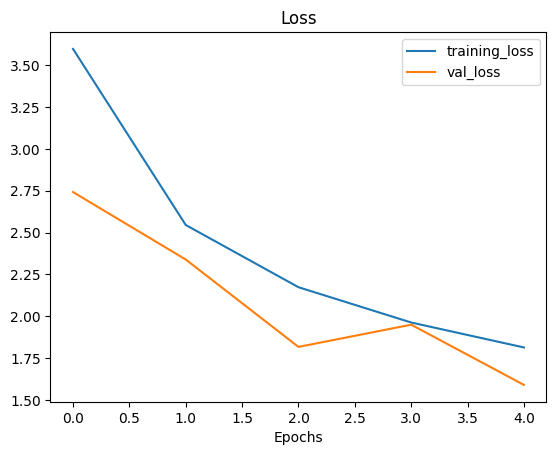

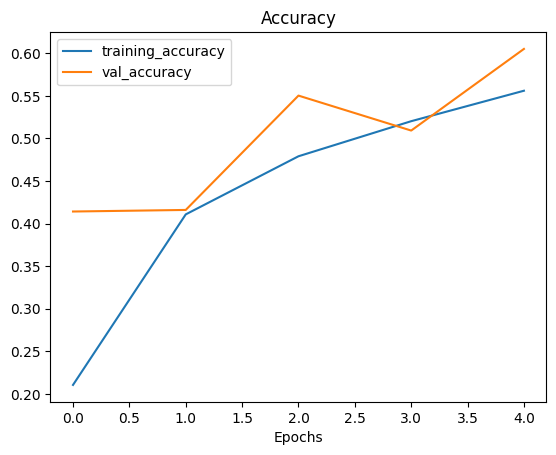

In [12]:
# Plot loss curves.

plot_loss_curves(history_all_classes_10_percent)

## Fine-tuning

In [13]:
# Unfreeze all of the layers in the base model

base_model.trainable = True

# Refreeze every layer except for the last 5.
for layer in base_model.layers[:-5]:
  layer.trainable = False

In [14]:
# Recompile model with lower learning rate.....
model.compile(
    loss = "categorical_crossentropy",
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001),
    metrics = ["accuracy"]
)

In [15]:
for layer in model.layers:
  print(layer.name, layer.trainable)

input_layer True
data_augmentation True
efficientnetb0 True
global_average_pooling_layer True
output_layer True


In [16]:
 # Check which layers are trainable in our base model.
 for layer_number, layer in enumerate(model.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

0 input_layer False
1 rescaling False
2 normalization False
3 rescaling_1 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze Fals

In [17]:
# Fine-tune for more epochs.

fine_tune_epochs = 10  # we have done 5 epochs for feature extraction. let add another 5 for fine-tuning.

# Fine-tune our model
history_all_classes_10_percent_fine_tune = model.fit(
    train_data_all_10_percent.repeat(),
    epochs = fine_tune_epochs,
    steps_per_epoch = len(train_data_all_10_percent),
    validation_data = test_data,
    validation_steps = int(0.15 * len(test_data)),
    initial_epoch = history_all_classes_10_percent.epoch[-1],   # Continue training where you finish in the feature extraction model.
    callbacks = [checkpoint_callback]
)

Epoch 5/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 53s 177ms/step - accuracy: 0.5627 - loss: 1.7801 - val_accuracy: 0.4963 - val_loss: 1.9814
Epoch 6/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 40s 170ms/step - accuracy: 0.6050 - loss: 1.6039 - val_accuracy: 0.5289 - val_loss: 1.7654
Epoch 7/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 40s 168ms/step - accuracy: 0.6331 - loss: 1.4897 - val_accuracy: 0.6017 - val_loss: 1.5521
Epoch 8/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 39s 165ms/step - accuracy: 0.6531 - loss: 1.4006 - val_accuracy: 0.5710 - val_loss: 1.6560
Epoch 9/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 38s 163ms/step - accuracy: 0.6699 - loss: 1.3299 - val_accuracy: 0.6224 - val_loss: 1.4646
Epoch 10/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 39s 164ms/step - accuracy: 0.6770 - loss: 1.2923 - val_accuracy: 0.6049 - val_loss: 1.4388


In [18]:
# Evaluate oon the whole test dataset.
all_classes_10_percent_fine_tune_results = model.evaluate(test_data)
all_classes_10_percent_fine_tune_results

790/790 ━━━━━━━━━━━━━━━━━━━━ 58s 74ms/step - accuracy: 0.5533 - loss: 1.7039


[1.606585144996643, 0.5742970108985901]

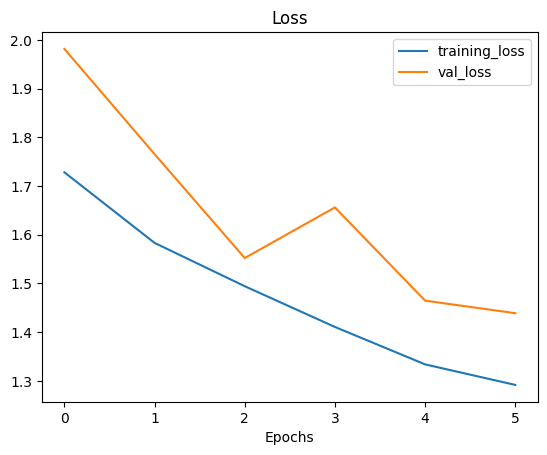

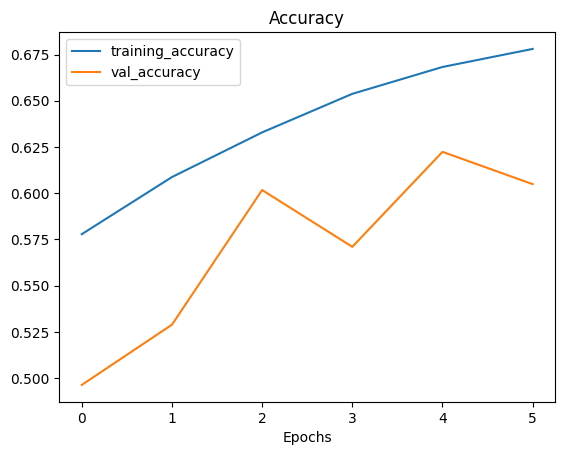

In [19]:
# plot loss curves.
plot_loss_curves(history_all_classes_10_percent_fine_tune)

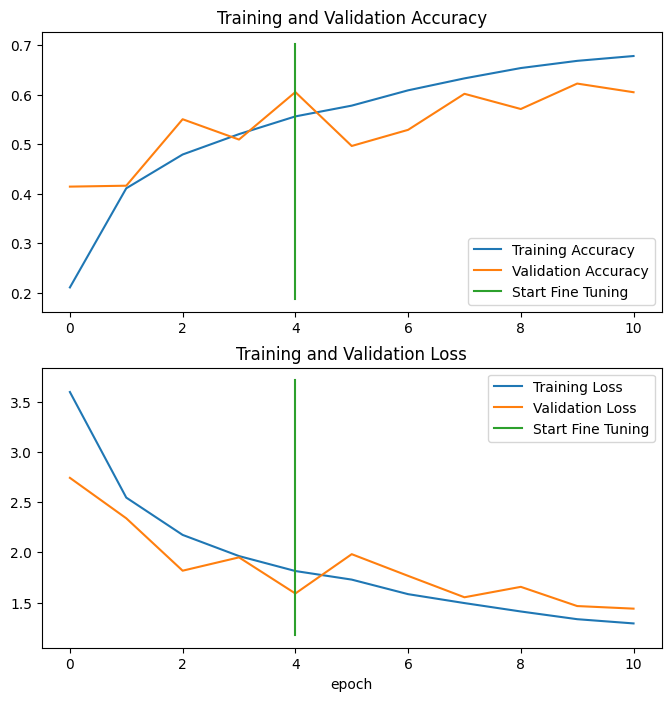

In [20]:
# Compare history of feature extraction model with fine-tuning model.
compare_historys(history_all_classes_10_percent, history_all_classes_10_percent_fine_tune)

## Saving and loading our model.

To use our model in an external application, we'll need to save and load it somehow.

In [21]:
from google.colab import drive
# drive.mount('drive/MyDrive/')

In [22]:
from google.colab import drive
drive.mount('/content/mydrive/dogvision')

ValueError: Mountpoint must be in a directory that exists

In [35]:
# Load and evaluate saved model.

loaded_model = tf.keras.models.load_model("")

ValueError: File format not supported: filepath=. Keras 3 only supports V3 `.keras` files and legacy H5 format files (`.h5` extension). Note that the legacy SavedModel format is not supported by `load_model()` in Keras 3. In order to reload a TensorFlow SavedModel as an inference-only layer in Keras 3, use `keras.layers.TFSMLayer(, call_endpoint='serving_default')` (note that your `call_endpoint` might have a different name).

In [23]:
# Evaluate loaded model and compare performance to pre-saved model.
evaluate_model = model.evaluate(test_data)
evaluate_model

790/790 ━━━━━━━━━━━━━━━━━━━━ 58s 73ms/step - accuracy: 0.5533 - loss: 1.7039


[1.606585144996643, 0.5742970108985901]

## Evaluating the performance of the big dog model across all different classes.

Let's make some predictions, visualize them and then later find out which predictions were the "most" wrong.

In [24]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip

--2024-12-26 09:19:22--  https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.11.207, 108.177.12.207, 74.125.26.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.11.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46760742 (45M) [application/zip]
Saving to: ‘06_101_food_class_10_percent_saved_big_dog_model.zip’

06_101_food_class_1 100%[===================>]  44.59M   138MB/s    in 0.3s    

2024-12-26 09:19:23 (138 MB/s) - ‘06_101_food_class_10_percent_saved_big_dog_model.zip’ saved [46760742/46760742]



In [27]:
# Download pretrain model. one prepared earlier so all predictions are similar.
unzip_data('/content/06_101_food_class_10_percent_saved_big_dog_model.zip')

In [29]:
# Load in save model
from tensorflow.keras.layers import TFSMLayer

model = TFSMLayer("/content/06_101_food_class_10_percent_saved_big_dog_model", call_endpoint='serving_default')
model

<TFSMLayer name=tfsm_layer, built=True>